# Building a yield curve using US Treasury T-bill data

In the *Intro to quandl and iexfinance* notebook, we learned how to pull US Treasury data from the US Federal Reserve bank site. We are going to pull prices for T-bills out to 52 weeks maturity, and use that data to build functions that can price a zero coupon with any maturity less than a year.

Here we copy some useful bits of that notebook, and tweak the plot function to plot interest rates.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import quandl

# replace YOUR_API_KEY with key from https://www.quandl.com/account/profile
quandl.ApiConfig.api_key = 'FA6wt7Na6c5FdbqM96i4'

def plot_interest_rates_pp(time_series):
    fig, (histo, qq) = plt.subplots(1, 2, figsize=(12, 4))
    histo.hist(time_series, bins = 20)
    histo.set_title('Distribution of rates')
    histo.set_xlabel('rate')
    histo.set_ylabel('frequency')
    stats.probplot(time_series, dist='norm', plot=plt)
    plt.show()

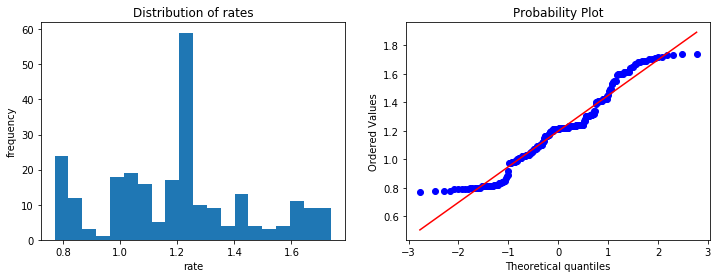

In [15]:
# get quandl 2017 data from USTREASURY/BILLRATES
ust_df = quandl.get('USTREASURY/BILLRATES', start_date='2017-01-01', end_date='2017-12-31')

# Print a list of columns. Which columns do we want?
# list(ust_df)

# Drop the columns we don't want
for col in list(ust_df):
    if (col.find('Coupon Equiv') == -1):
        ust_df.drop([col], axis=1, inplace=True)
ust_df.drop(['8 Wk Coupon Equiv'], axis=1, inplace=True)
ust_df.tail()
        
# Plot the one year series to visually check for any data anomalies. Make corrections.
one_year_ust_series = ust_df['52 Wk Coupon Equiv']
one_year_ust_series.tail()

one_year_ust_series = one_year_ust_series[one_year_ust_series > 0]
plot_interest_rates_pp(one_year_ust_series)

We would like some longer maturity data, but we can attend to that later. We have enough data to start modeling. Treasury bills have no coupon. The purchase price is a percentage of face value. The coupon equivalent represents the annual yield the holder earns. The price $p$ and coupon equivalent $c$ [are related as follows](https://www.investopedia.com/terms/c/couponequivalentrate.asp):

$ c = \frac{1-p}{p} \frac{y}{m} $

where $y$ is the number of days in the year ([365 or 366](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=billrates)), and $m$ is the number of days to maturity. We want to convert the coupon yield to a continuously compounded rate $r$, which we can get from the price. So we solve for $p$:

$ p = \frac{1}{1 + c \frac{m}{365}}$

Since $p=e^{-rt}$, and $t = \frac{m}{y}$, we have $r = -\frac{\ln p}{m/y}$.

In [16]:
def price(coupon_equiv, maturity):
    return 1 / (1 + coupon_equiv * maturity / 365)

print(price(0.12, 28))

0.9908784884352263


In [46]:
import math
def rate(price, maturity_in_days):
    return -math.log(price) / (maturity_in_days / 365)
print(rate(price(0.022, 28), 28))

0.021981456477085673


Buying a holding a note to maturity is equivalent to constantly investing at the instantaneous forward rate. So $rt = \int_0^t f(s) ds$. Of course, we can't observe $f(t)$. But if we assume that it is piecewise flat, then we can determine $f(t)$ for all $t$ up to the maximum maturity of our zeroes. 

Let $t_0=0$, and let $t_1 < ... < t_n$ be the maturities of the zeroes. Define $f_i$ to be the instantaneous forward rate on $(t_{i-1}, t_i]$.

If we define $r_i$ to be the continuously compounded rate to time $t_i$, then $r_i t_i =r_{i-1}t_{i-1} + f_i(t_i-t_{i-1})$. Hence $f_i = \frac{r_i t_i - r_{i-1}t_{i-1}}{t_i-t_{i-1}}$.

To model this, we create a term structure object.

In [28]:
class RateTermStructure:
    def __init__(self, maturity_list, zero_rate_list):
        self.times_in_years = list(maturity_list)
        self.zero_rates = list(zero_rate_list)
        self.forward_rates = []
        r_previous = 0
        t_previous = 0
        for t, r in zip(self.times_in_years, self.zero_rates):
            self.forward_rates.append( (r * t - r_previous * t_previous) / (t - t_previous))
            r_previous = r
            t_previous = t
            
    def format_rate(self, x):
        return '{:{width}.{prec}f}'.format(x, width=6, prec=4)
            

    def format_time(self, x):
        return '{:{width}.{prec}f}'.format(x, width=5, prec=2)
    
    def forward_rate_cc(self, years):
        for t, r in zip(self.times_in_years, self.forward_rates):
            if t > years:
                return r
        return float('nan')     

    
    def zero_rate_cc(self, years):
        if years == 0:
            return self.forward_rates[0]
        # accumulate rate
        rate = 0
        t_previous = 0
        for t, r in zip(self.times_in_years, self.forward_rates):
            if t < years:
                rate += r * (t - t_previous)
            else:
                return (rate + r * (years - t_previous)) / years
            t_previous = t
        return float('nan')     


    def __repr__(self):
        return str([self.format_time(t)+'->'+self.format_rate(f) for t, f in zip(self.times_in_years,self.forward_rates )])

# create a list of maturity times (in years)
weeks = [4, 13, 26, 52]
times =  [ 7 * w / 365.0 for w in weeks ]
# pick a date for testing purposes
# print(times)
date = ust_df.index[0]
# print(date)
# extract rates for that date
zero_rates = [0.01 * ust_df[col][date] for col in list(ust_df)]
# print(zero_rates)
rts = RateTermStructure(times, zero_rates)
print(rts)
# test forward rate
rts.forward_rate_cc(0.49)

[' 0.08->0.0052', ' 0.25->0.0055', ' 0.50->0.0076', ' 1.00->0.0113']


0.007600000000000001

Let's graph the instantaneous forward and zero curves.

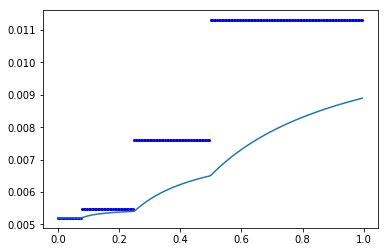

In [29]:
import matplotlib.pyplot as plt

# use numpy to create a range of numbers from 0 to 1
times = np.arange(0, 1, 0.005)
# compute flat forward rates, and zero rates for those times
ffr = [rts.forward_rate_cc(t) for t in times]
zero_rates = [rts.zero_rate_cc(t) for t in times]

# plot it
plt.plot(times, ffr, 'bo', markersize=2)
plt.plot(times, zero_rates)